# Discovering Insights from Chess Games

**Primary Objective**: Perform exploratory analysis of chess game data to understand distributions of player skills, outcomes, openings, and basic play patterns before constructing an Elo prediction model.

**Raw Data**: Portable Game Notation (PGN) files containing moves from 25,000 expert chess games, player Elo ratings, openings, and Stockfish evaluations.

**Plan**:
* Compute summary statistics on games: lengths, results, openings, theory depth
* Visualize Elo distributions and correlations
* Sample games across the Elo spectrum and inspect move patterns
* Validate data integrity: correct notation, valid moves, matched results
* Identify anomalies: incomplete games, duplicate matches, odd evaluations

**Learnings**:
* Game length, result, and opening trends for different Elo levels
* Imbalances and biases in player populations or outcomes
* Adherence to opening theory by players of varying skill
* General play patterns and trajectories in games
* Data quality and completeness for modeling
* Peculiar games or moves that require investigation

First, we gotta check out how good the players are, what moves they tend to make, and how their games usually turn out. Once we've got a good sense of all that, we can dive deeper into the data and start figuring out what's really going on. This will help us spot any problems and establish a solid analysis foundation.

In [1]:
from os.path import abspath
from sys import path as sys_path

sys_path.append(abspath(".."))
[p for p in sys_path if p.endswith("finding-elo-aug-2023")]

['/Users/ian.castillo/Documents/my-kaggle-tools/competitions/finding-elo-aug-2023']

### 0. Libraries

In [2]:
# import chess
import chess.pgn
import pandas as pd
from src.features.main import pgn_to_dataframe

In [3]:
# Set the display option to show all columns
pd.set_option("display.max_columns", None)

### 1. Get PGN Chess Data

In [4]:
PGN_FILE = "../data/raw/small_data.pgn"

In [5]:
pgn = open(PGN_FILE)
game_count = 0
moves_per_game = []

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    game_count += 1
    moves_per_game.append(len(list(game.mainline_moves())))

pgn.close()

In [6]:
print(f"The number of games in the file is: {game_count:,d}")

The number of games in the file is: 1,000


### 2. Distribution of Total Moves Per Game

In [7]:
print(
    f"Average number of moves per game: {sum(moves_per_game)/len(moves_per_game):.2f}"
)

print(f"Min number of moves per game: {min(moves_per_game):,d}")
print(
    f"25th percentile of moves per game: {sorted(moves_per_game)[int(len(moves_per_game)*0.25)]:,d}"
)
print(
    f"50th percentile of moves per game: {sorted(moves_per_game)[int(len(moves_per_game)*0.50)]:,d}"
)
print(
    f"75th percentile of moves per game: {sorted(moves_per_game)[int(len(moves_per_game)*0.75)]:,d}"
)
print(f"Max number of moves per game: {max(moves_per_game):,d}")

Average number of moves per game: 81.32
Min number of moves per game: 1
25th percentile of moves per game: 60
50th percentile of moves per game: 78
75th percentile of moves per game: 100
Max number of moves per game: 269


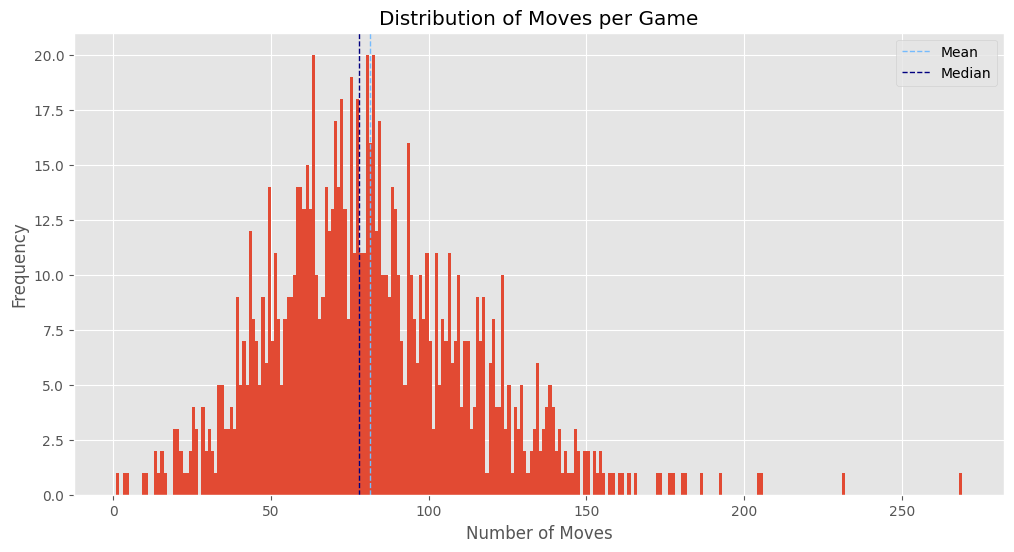

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [12, 6]
plt.style.use("ggplot")

# Calculate the mean and median of the distribution and return float values
mean_moves = np.mean(moves_per_game).astype(float)
median_moves = np.median(moves_per_game).astype(float)

# Create a histogram to visualize the distribution of moves per game
plt.hist(moves_per_game, bins=range(min(moves_per_game), max(moves_per_game) + 1))
plt.title("Distribution of Moves per Game")
plt.xlabel("Number of Moves")
plt.ylabel("Frequency")

# Add vertical lines to indicate the mean and median
plt.axvline(
    mean_moves, color="xkcd:sky blue", linestyle="dashed", linewidth=1, label="Mean"
)
plt.axvline(median_moves, color="navy", linestyle="dashed", linewidth=1, label="Median")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [9]:
print(
    f"Proportion of games shorter than average: {sum([1 for x in moves_per_game if x < sum(moves_per_game)/len(moves_per_game)]) / len(moves_per_game):.1%}"
)

Proportion of games shorter than average: 55.0%


It appears that the distribution of total moves per game has a peak around 80 moves. This suggests that most of the games in the PGN file have around 100 moves. The range of the x-axis indicates that there are games with as few as 1 moves and as many as 300 moves.

Some interesting insights that can be derived from this distribution include:

- [x] The average length of a game in terms of the number of moves.
- [x] The proportion of games that are shorter or longer than the average game length.
- [ ] The presence of any outliers or unusual patterns in the distribution.

#### 2. 1. Deep Dive into Game Movements Distribution

To investigate the data further, let's ask ourselves questions such as:

- [ ] Are there any patterns or trends in the distribution of moves per game? *To answer this question, you can use visualization techniques such as histograms and box plots to explore the distribution of moves per game. You can also use statistical tests such as the chi-squared test or the Kolmogorov-Smirnov test to determine if the distribution follows a known pattern or if there are any significant differences between groups.*

- [ ] Are there any differences in the distribution of moves per game for different players, openings, or other factors? *To answer this question, you can use regression analysis or analysis of variance (ANOVA) to investigate the relationship between the number of moves per game and other variables such as player skill level, opening choice, or time control. This will help you determine if there are any significant differences in the distribution of moves per game for different groups.*

- [ ] Are there any unusually short or long games, and if so, what might explain these outliers? *To answer this question, you can use descriptive statistics to identify any outliers in the data. You can then use techniques such as cluster analysis or factor analysis to investigate the characteristics of these outliers and determine what might explain their unusual length.*

### 3. Feature Engineering

Converting the PGN to a `pandas.DataFrame` can enable lots of additional analysis on the chess games. A few other ideas for enhancements:

- [x] Add columns for additional info from the PGN headers like player names, ratings, dates, etc
- [x] Track the moves for each individual player rather than just total moves
- [x] Add columns for other metrics like number of captures, checks, etc
- [x] Add columns for metrics related to openings
- [ ] Check for how many mate in N occurances there are in each game

In [10]:
PGN_FILE = "../data/raw/medium_data.pgn"
raw_df = pgn_to_dataframe(PGN_FILE)

In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   rating_diff          10000 non-null  int64 
 1   wp_rating            10000 non-null  object
 2   bp_rating            10000 non-null  object
 3   result               10000 non-null  object
 4   total_moves          10000 non-null  int64 
 5   wp_total_moves       10000 non-null  int64 
 6   bp_total_moves       10000 non-null  int64 
 7   wp_total_P_moves     10000 non-null  int64 
 8   bp_total_P_moves     10000 non-null  int64 
 9   wp_total_N_moves     10000 non-null  int64 
 10  bp_total_N_moves     10000 non-null  int64 
 11  wp_total_B_moves     10000 non-null  int64 
 12  bp_total_B_moves     10000 non-null  int64 
 13  wp_total_R_moves     10000 non-null  int64 
 14  bp_total_R_moves     10000 non-null  int64 
 15  wp_total_Q_moves     10000 non-null  int64 
 16  bp_to

In [12]:
raw_df.sample(1).iloc[0]

rating_diff             -486
wp_rating               1916
bp_rating               2402
result                   0-1
total_moves              103
wp_total_moves            52
bp_total_moves            52
wp_total_P_moves          12
bp_total_P_moves          14
wp_total_N_moves          10
bp_total_N_moves           7
wp_total_B_moves          10
bp_total_B_moves          15
wp_total_R_moves          15
bp_total_R_moves          10
wp_total_Q_moves           1
bp_total_Q_moves           0
wp_total_K_moves           4
bp_total_K_moves           5
wp_total_checks            3
bp_total_checks            3
wp_total_captures          8
bp_total_captures          9
wp_total_promotions        0
bp_total_promotions        0
wp_bool_castles         True
bp_bool_castles        False
Name: 9046, dtype: object

In [13]:
raw_df.to_csv("../data/interim/medium_data.csv", index=False)